# Covariance Matrices in High Dimensions

### Sang-Yun Oh

In [1]:
import pandas as pd
logret = pd.read_pickle('dowjones-logreturns.pkl').dropna()

import sklearn.covariance as skcov
import sklearn.model_selection as sksel
import numpy.linalg as npl

## Sample Covariance Matrix

$$
\mathbf{S}=\frac{1}{n} \sum_{i=1}^{n}\left(\boldsymbol{Y}_{i}-\overline{\boldsymbol{Y}}\right)\left(\boldsymbol{Y}_{i}-\overline{\boldsymbol{Y}}\right)^{\prime},
$$

* MLE of covariance matrix for Gaussian data
* Singular in high dimensional setting: Zero eigenvalues 
* When $p>n$, other covariance estimates are needed

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


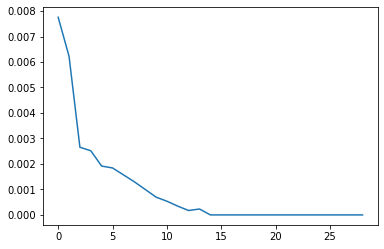

In [2]:
cov_sample = skcov.empirical_covariance(logret[:15])
eigval_sample, eigvec_sample = npl.eig(cov_sample)
pd.Series(eigval_sample).plot();

## Ledoit-Wolf Estimator 
$$
\Sigma_{\text {LW}}=(1-\alpha) \mathbf{S}+\alpha \frac{\operatorname{Tr} \mathbf{S}}{p} \text { I }
$$

* Ledoit and Wolf, 2004 ([documentation page](https://scikit-learn.org/stable/modules/covariance.html#shrunk-covariance))
* Weighted average between sample covariance and identity (times average eigenvalue)

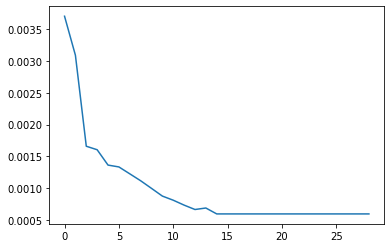

In [3]:
cov_lw, shrinkage_lw = skcov.ledoit_wolf(logret[:15])
eigval_lw, eigvec_lw = npl.eig(cov_lw)
pd.Series(eigval_lw).plot();

* Large eigenvalues decrease
* Zero eigenvalues increase (not sigular) 

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


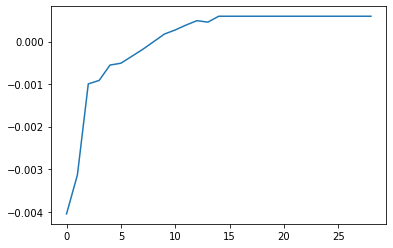

In [4]:
pd.Series(eigval_lw - eigval_sample).plot();

## Graphical Model

* Suppose $X = (X_a, X_b, X_c)^T \sim N(0, \Sigma)$ then,
* $\Omega= \Sigma^{-1}$ encodes multivariate relationship (rather than pairwise)
$$
\operatorname{cor}\left(X_{a}, X_{b} \mid X_{c}: c \neq a, b\right)=\frac{\operatorname{cov}\left(X_{a}, X_{b} \mid X_{c}: c \neq a, b\right)}{\sqrt{\operatorname{var}\left(X_{a} \mid X_{c}: c \neq a, b\right) \operatorname{var}\left(X_{b} \mid X_{c}: c \neq a, b\right)}}\\
=\frac{-\Omega_{a b}}{\sqrt{\Omega_{a a} \Omega_{b b}}}
$$
* $\Omega$ is useful for understanding relationships

In [5]:
edge_model = skcov.GraphicalLassoCV(n_refinements=2)
edge_model.fit(logret[:15])
omega = edge_model.precision_.copy()
cov_ggm = npl.inv(omega)
eigval_ggm, eigvec_ggm = npl.eig(cov_ggm)

/opt/conda/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:243: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = (- precision_[idx, idx]
/opt/conda/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:245: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = (- precision_[idx, idx]
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


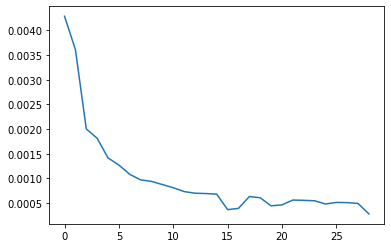

In [6]:
pd.Series(eigval_ggm).plot();

### Visualize Graphical Model

In [7]:
from bokeh.io import show, output_file, output_notebook
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, 
                          HoverTool, MultiLine, NodesAndLinkedEdges, 
                          Plot, Range1d, TapTool, LabelSet, 
                          ColumnDataSource)
from bokeh.plotting import from_networkx
from bokeh.palettes import Spectral4
output_notebook()

import networkx as nx
G = nx.from_pandas_adjacency(pd.DataFrame(omega, columns=logret.columns.to_list(), index=logret.columns.to_list()))

Loading BokehJS ...

In [8]:
plot = Plot(plot_width=600, plot_height=600,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot.title.text = "Dow Jones Component Stock Graphical Models"

graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool())
plot.renderers.append(graph_renderer)

# add labels
pos = nx.circular_layout(G)
x, y=zip(*pos.values())

source = ColumnDataSource({'x':x,'y':y,'ticker':logret.columns.to_list()})
labels = LabelSet(x='x', y='y', text='ticker', source=source)

plot.renderers.append(labels)

show(plot)

## Compare Eigenvalues

* Different estimates perform different regularization
* There are similairies as well as differences

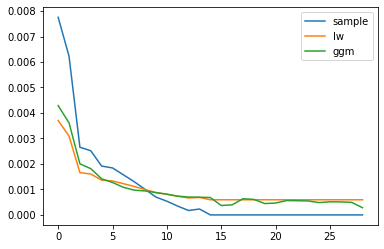

In [9]:
import numpy as np
allevals = pd.DataFrame({
    "sample": np.real(eigval_sample),
    "lw": eigval_lw,
    "ggm": eigval_ggm
})
allevals.plot();